# 0. Setup

In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

# 1. Data Extraction

We filter for the county that was assigned for analysis and the required date range.

Name: Salt Lake County

Date range: Feb 1, 2020 to Oct 1, 2021

## 1.1 Load data from CSV sources

In [2]:
covid_cases = pd.read_csv("RAW_us_confirmed_cases.csv")
mask_use = pd.read_csv("mask-use-by-county.csv")
mask_mandate = pd.read_csv("US_State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")

In [3]:
covid_cases.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,18480,18480,18480,18480,18480,18480,18511,18511,18511,18511
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,65895,65895,65895,65895,65895,65895,65973,65973,65973,65973
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,6926,6926,6926,6926,6926,6926,6930,6930,6930,6930
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,...,7560,7560,7560,7560,7560,7560,7575,7575,7575,7575
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,...,17286,17286,17286,17286,17286,17286,17320,17320,17320,17320


In [4]:
mask_use.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [5]:
mask_mandate.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,4/10/2020,2,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,4/11/2020,2,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,4/12/2020,2,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,4/13/2020,2,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,4/14/2020,2,NaN,NaN,NaN,NaN


## 1.2 Filter data for Salt Lake County, Utah

In [6]:
# Extracting data for Salt Lake County, Utah

covid_cases = covid_cases.loc[(covid_cases['Province_State'] == 'Utah') & (covid_cases['Admin2'] == 'Salt Lake')]
covid_cases.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22
2976,Utah,Salt Lake,84049035,US,USA,840,49035.0,US,40.666165,-111.921601,...,392045,392045,392045,392045,392045,392045,392864,392864,392864,392864


We find that the FIPS code for the county is 49035. Only one row of data was returned but each day's case count is a separate column. We will have to clean that before we can proceed.

In [7]:
# Extracting mask use data
mask_use = mask_use.loc[mask_use['COUNTYFP'] == 49035]
mask_use.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
2794,49035,0.028,0.032,0.094,0.202,0.644


In [8]:
# Extracting mask mandate data
mask_mandate =  mask_mandate.loc[(mask_mandate["FIPS_State"] == 49) & (mask_mandate["FIPS_County"] == 35)]
mask_mandate.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
743140,UT,Salt Lake County,49,35,4/13/2020,2,NaN,NaN,NaN,NaN
743177,UT,Salt Lake County,49,35,4/14/2020,2,NaN,NaN,NaN,NaN
743206,UT,Salt Lake County,49,35,4/10/2020,2,NaN,NaN,NaN,NaN
743207,UT,Salt Lake County,49,35,4/11/2020,2,NaN,NaN,NaN,NaN
743208,UT,Salt Lake County,49,35,4/12/2020,2,NaN,NaN,NaN,NaN


## 1.3 Filter data for Feb 1, 2020 to Oct 1, 2021

In [9]:
# Pivot the data
date_cols = [col for col in covid_cases.columns if re.search(r'(\d{1,2}/)+\d{2}', col)]
covid_cases = covid_cases.melt(id_vars=['Admin2', 'Province_State',], value_vars=date_cols, var_name='Date', value_name='Cases')
covid_cases["Date"] = pd.to_datetime(covid_cases["Date"])
covid_cases = covid_cases[(covid_cases["Date"] >= "2020-02-01") & (covid_cases["Date"] <= "2021-10-01")]
covid_cases.head()

,Admin2,Province_State,Date,Cases
10,Salt Lake,Utah,2020-02-01,0
11,Salt Lake,Utah,2020-02-02,0
12,Salt Lake,Utah,2020-02-03,0
13,Salt Lake,Utah,2020-02-04,0
14,Salt Lake,Utah,2020-02-05,0


In [10]:
covid_cases.describe(include='all', datetime_is_numeric=True)

,Admin2,Province_State,Date,Cases
count,609,609,609,609.000000
unique,1,1,NaN,NaN
top,Salt Lake,Utah,NaN,NaN
freq,609,609,NaN,NaN
mean,NaN,NaN,2020-12-01 00:00:00,81164.729064
min,NaN,NaN,2020-02-01 00:00:00,0.000000
25%,NaN,NaN,2020-07-02 00:00:00,11728.000000
50%,NaN,NaN,2020-12-01 00:00:00,81337.000000
75%,NaN,NaN,2021-05-02 00:00:00,148226.000000
max,NaN,NaN,2021-10-01 00:00:00,183169.000000


In [11]:
mask_mandate["date"] = pd.to_datetime(mask_mandate["date"])
mask_mandate = mask_mandate[(mask_mandate["date"] >= "2020-02-01") & (mask_mandate["date"] <= "2021-10-01")]
mask_mandate.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
743140,UT,Salt Lake County,49,35,2020-04-13,2,NaN,NaN,NaN,NaN
743177,UT,Salt Lake County,49,35,2020-04-14,2,NaN,NaN,NaN,NaN
743206,UT,Salt Lake County,49,35,2020-04-10,2,NaN,NaN,NaN,NaN
743207,UT,Salt Lake County,49,35,2020-04-11,2,NaN,NaN,NaN,NaN
743208,UT,Salt Lake County,49,35,2020-04-12,2,NaN,NaN,NaN,NaN


## 1.4 Save Data Extracts to Files

In [12]:
covid_cases.to_csv("covid_cases.csv", index=False)
mask_use.to_csv("mask_use.csv", index=False)
mask_mandate.to_csv("mask_mandate.csv", index=False)

# 2. Analysis

Now that we have the data we can visualize it. The raw data file has cumulative case counts. We want to see daily cases so we take a day by day difference.

## 2.1 COVID-19 Cases Data

In [13]:
covid_cases["daily_cases"] = covid_cases["Cases"].diff()
covid_cases.head()

,Admin2,Province_State,Date,Cases,daily_cases
10,Salt Lake,Utah,2020-02-01,0,NaN
11,Salt Lake,Utah,2020-02-02,0,0.0
12,Salt Lake,Utah,2020-02-03,0,0.0
13,Salt Lake,Utah,2020-02-04,0,0.0
14,Salt Lake,Utah,2020-02-05,0,0.0


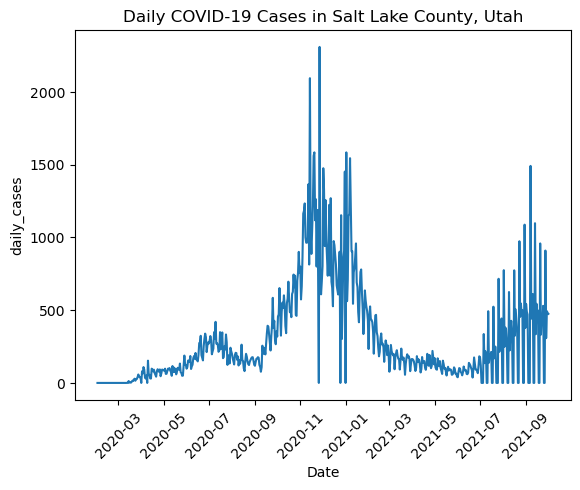

In [14]:
sns.lineplot(data=covid_cases, x="Date", y="daily_cases");
plt.title("Daily COVID-19 Cases in Salt Lake County, Utah");
plt.xticks(rotation=45);

We see that this is very noisy and has a lot of fluctuation. We can use a moving average with a window of 7 days. We use 7 days because it is known that case reporting is lower on the weekends which makes it look like the spread is lesser on the weekend.

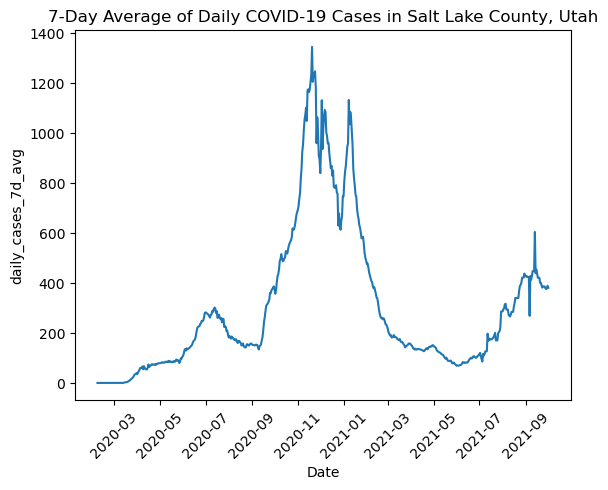

In [15]:
covid_cases["daily_cases_7d_avg"] = covid_cases["daily_cases"].rolling(7).mean()
sns.lineplot(data=covid_cases, x="Date", y="daily_cases_7d_avg");
plt.title("7-Day Average of Daily COVID-19 Cases in Salt Lake County, Utah");
plt.xticks(rotation=45);

Much better. We want to explore how masking policies affected the spread of COVID-19. For this we could observe the rate of change of daily COVID-19 cases around the time masking policies were enforced. Let us calculate the day-over-day change in COVID cases and visualize it. We will calculate the percentage over the 7-day average since the daily change can be very noisy without smothing the series. This step was inspired by some experimentation and an observation made [here](https://stackoverflow.com/a/14082657).

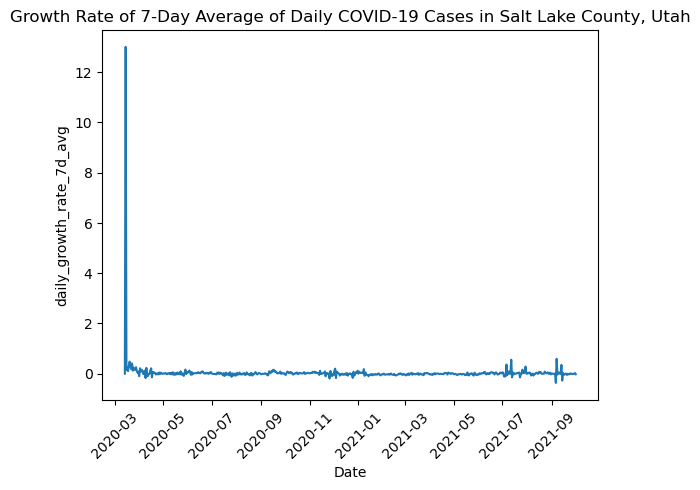

In [16]:
covid_cases["daily_growth_rate_7d_avg"] = covid_cases["daily_cases_7d_avg"].pct_change()
sns.lineplot(data=covid_cases, x="Date", y="daily_growth_rate_7d_avg");
plt.title("Growth Rate of 7-Day Average of Daily COVID-19 Cases in Salt Lake County, Utah");
plt.xticks(rotation=45);

It looks like a lot of noise comes from the initial percentage changes. Let us see what the data looks like. We can try plotting this again after removing those outliers.

In [17]:
covid_cases[covid_cases["Cases"]>0].head(20)

,Admin2,Province_State,Date,Cases,daily_cases,daily_cases_7d_avg,daily_growth_rate_7d_avg
51,Salt Lake,Utah,2020-03-13,1,1.0,0.142857,inf
52,Salt Lake,Utah,2020-03-14,1,0.0,0.142857,0.000000
53,Salt Lake,Utah,2020-03-15,14,13.0,2.000000,13.000000
54,Salt Lake,Utah,2020-03-16,16,2.0,2.285714,0.142857
55,Salt Lake,Utah,2020-03-17,20,4.0,2.857143,0.250000
56,Salt Lake,Utah,2020-03-18,22,2.0,3.142857,0.100000
57,Salt Lake,Utah,2020-03-19,29,7.0,4.142857,0.318182
58,Salt Lake,Utah,2020-03-20,44,15.0,6.142857,0.482759
59,Salt Lake,Utah,2020-03-21,57,13.0,8.000000,0.302326
60,Salt Lake,Utah,2020-03-22,80,23.0,9.428571,0.178571


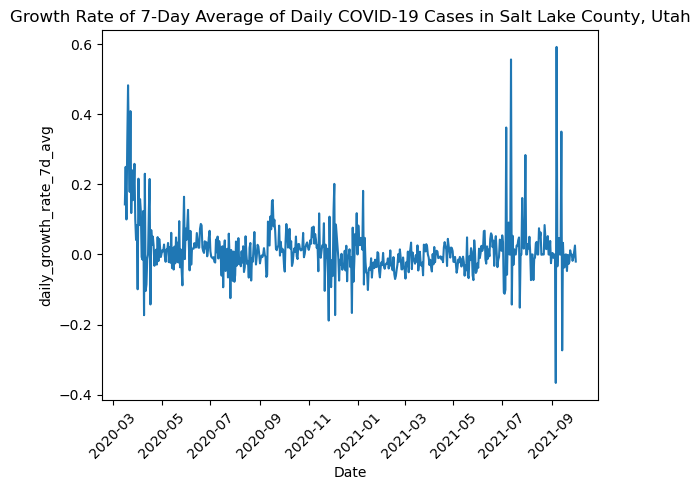

In [18]:
sns.lineplot(data=covid_cases.loc[54:,:], x="Date", y="daily_growth_rate_7d_avg");
plt.title("Growth Rate of 7-Day Average of Daily COVID-19 Cases in Salt Lake County, Utah");
plt.xticks(rotation=45);

Much better but still a little noisy. Let's try smoothing this series.

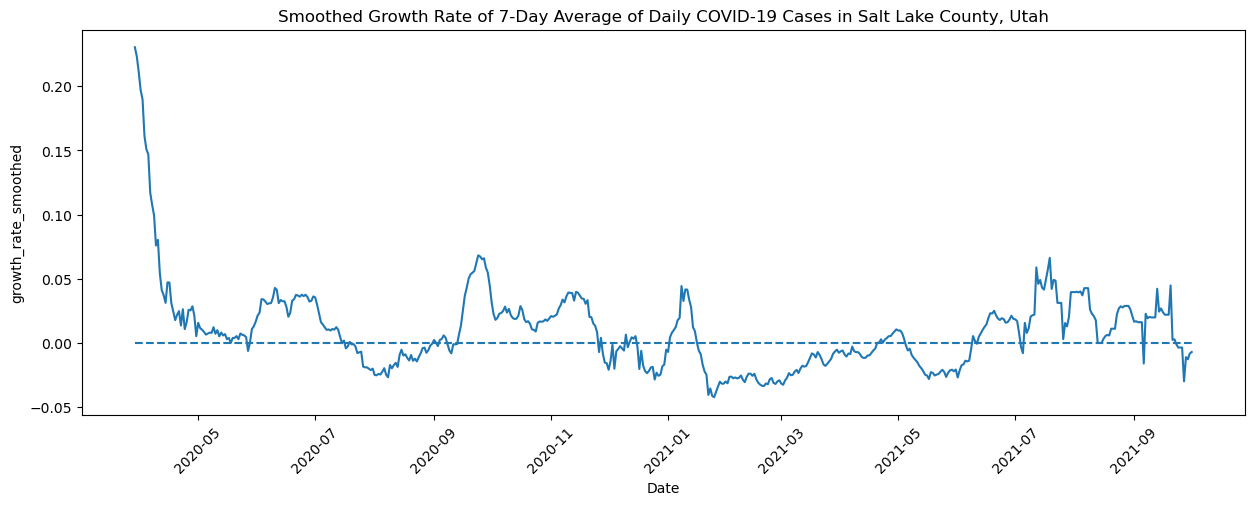

In [47]:
covid_cases["growth_rate_smoothed"] = covid_cases["daily_growth_rate_7d_avg"].rolling(14).mean()
plt.figure(figsize=(15,5))
sns.lineplot(data=covid_cases.loc[67:,:], x="Date", y="growth_rate_smoothed");
plt.hlines(0, covid_cases.loc[67, "Date"], covid_cases["Date"].max(), linestyles='dashed')
plt.title("Smoothed Growth Rate of 7-Day Average of Daily COVID-19 Cases in Salt Lake County, Utah");
plt.xticks(rotation=45);

A 14-day smoothing window allows us to observe the over-arching trend. We can now try to plot the dates where mandates were introduced and changed as vertical lines and check if there are any interesting patterns. There seems to be a lot of fluctuation when we model the daily data. 

We can first interpolate the mask mandate dates on this plot and see if we can see anything interesting. Else we can repeat this on weekly rolled up data.

We can also check if vaccinations had an effect on growth rate using this strategy.

The horizontal 0 line helps us see when case growth increasing or decreasing.

## 2.2 Mask Mandate Data

In [48]:
mask_mandate.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
743140,UT,Salt Lake County,49,35,2020-04-13,2,NaN,NaN,NaN,NaN
743177,UT,Salt Lake County,49,35,2020-04-14,2,NaN,NaN,NaN,NaN
743206,UT,Salt Lake County,49,35,2020-04-10,2,NaN,NaN,NaN,NaN
743207,UT,Salt Lake County,49,35,2020-04-11,2,NaN,NaN,NaN,NaN
743208,UT,Salt Lake County,49,35,2020-04-12,2,NaN,NaN,NaN,NaN


We check what the changepoints are for the mask mandate data. We can see clearly when face masks were mandated and when it was repealed from the plot below. We also note that the data has NaNs that have not been shown in the plot

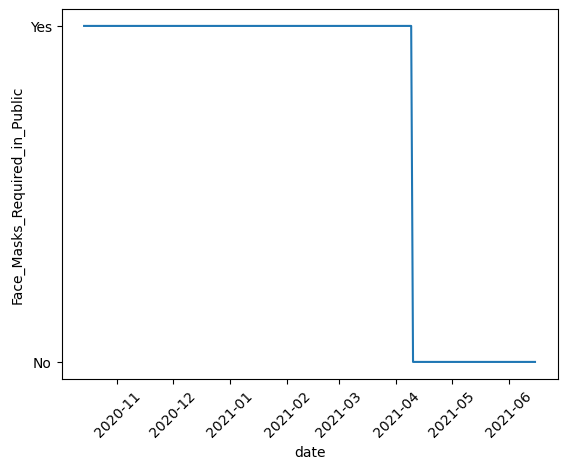

In [ ]:
sns.lineplot(data=mask_mandate, x="date", y="Face_Masks_Required_in_Public");
plt.xticks(rotation=45);    

There is also another column called `order_code` that seems to be an indicator of masking regulations

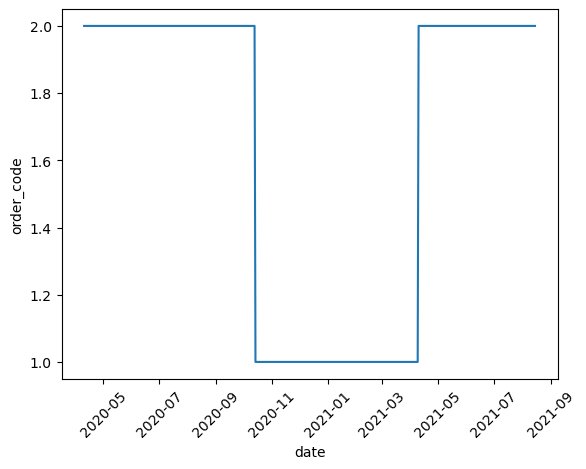

In [ ]:
sns.lineplot(data=mask_mandate, x="date", y="order_code");
plt.xticks(rotation=45);

The date range for this variable is longer. Perhaps the NaNs in the `Face_Masks_Required_in_Public` indicate no mandate issued, we can fill those values as No since there are no other breakages in the graph

In [49]:
mask_mandate["Face_Masks_Required_in_Public"] = mask_mandate["Face_Masks_Required_in_Public"].fillna("No")
mask_mandate

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
743140,UT,Salt Lake County,49,35,2020-04-13,2,No,NaN,NaN,NaN
743177,UT,Salt Lake County,49,35,2020-04-14,2,No,NaN,NaN,NaN
743206,UT,Salt Lake County,49,35,2020-04-10,2,No,NaN,NaN,NaN
743207,UT,Salt Lake County,49,35,2020-04-11,2,No,NaN,NaN,NaN
743208,UT,Salt Lake County,49,35,2020-04-12,2,No,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1494438,UT,Salt Lake County,49,35,2021-08-11,2,No,NaN,NaN,NaN
1494439,UT,Salt Lake County,49,35,2021-08-12,2,No,NaN,NaN,NaN
1494440,UT,Salt Lake County,49,35,2021-08-13,2,No,NaN,NaN,NaN
1494441,UT,Salt Lake County,49,35,2021-08-14,2,No,NaN,NaN,NaN


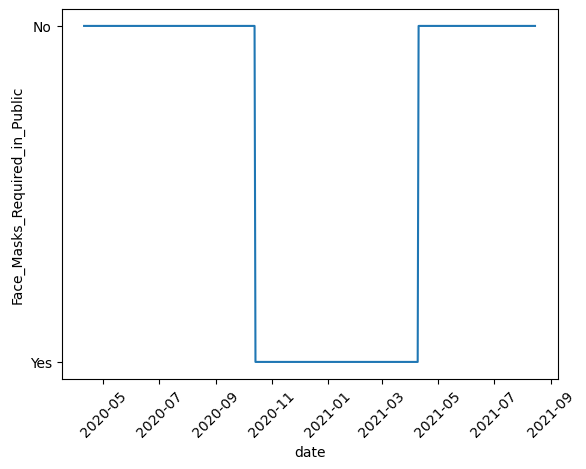

In [51]:
sns.lineplot(data=mask_mandate, x="date", y="Face_Masks_Required_in_Public");
plt.xticks(rotation=45);

Looks identical to the order code graph. Now we find the changepoints of the mandate.

In [55]:
mask_mandate.sort_values("date", inplace=True)
mask_mandate["Face_Masks_Required_Lag"] = mask_mandate["Face_Masks_Required_in_Public"].shift(1)
mask_mandate

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,Face_Masks_Required_Lag
743206,UT,Salt Lake County,49,35,2020-04-10,2,No,NaN,NaN,NaN,NaN
743207,UT,Salt Lake County,49,35,2020-04-11,2,No,NaN,NaN,NaN,No
743208,UT,Salt Lake County,49,35,2020-04-12,2,No,NaN,NaN,NaN,No
743140,UT,Salt Lake County,49,35,2020-04-13,2,No,NaN,NaN,NaN,No
743177,UT,Salt Lake County,49,35,2020-04-14,2,No,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...
1494438,UT,Salt Lake County,49,35,2021-08-11,2,No,NaN,NaN,NaN,No
1494439,UT,Salt Lake County,49,35,2021-08-12,2,No,NaN,NaN,NaN,No
1494440,UT,Salt Lake County,49,35,2021-08-13,2,No,NaN,NaN,NaN,No
1494441,UT,Salt Lake County,49,35,2021-08-14,2,No,NaN,NaN,NaN,No


In [56]:
mask_mandate["Face_Masks_Required_Lag"] = mask_mandate["Face_Masks_Required_Lag"].fillna("No")
mask_mandate[mask_mandate["Face_Masks_Required_Lag"] != mask_mandate["Face_Masks_Required_in_Public"]]

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,Face_Masks_Required_Lag
743392,UT,Salt Lake County,49,35,2020-10-14,1,Yes,Official,https://coronavirus-download.utah.gov/Health/S...,"Utah Health Directive (Oct. 14, 2020)",No
1494351,UT,Salt Lake County,49,35,2021-04-10,2,No,Official,https://coronavirus-download.utah.gov/Health/U...,"Utah Health Order No. 2021-10 (Apr. 9, 2021)",Yes


In [83]:
mask_no_1 = covid_cases.loc[67, "Date"].to_pydatetime(), mask_mandate.loc[mask_mandate["date"] == '2020-10-14',"date"].dt.to_pydatetime()[0]
mask_yes = mask_mandate.loc[mask_mandate["date"] == '2020-10-14',"date"].dt.to_pydatetime()[0], mask_mandate.loc[mask_mandate["date"] == '2021-04-10',"date"].dt.to_pydatetime()[0]
mask_no_2 = mask_mandate.loc[mask_mandate["date"] == '2021-04-10',"date"].dt.to_pydatetime()[0], covid_cases["Date"].max().to_pydatetime()

# 3. Visualize

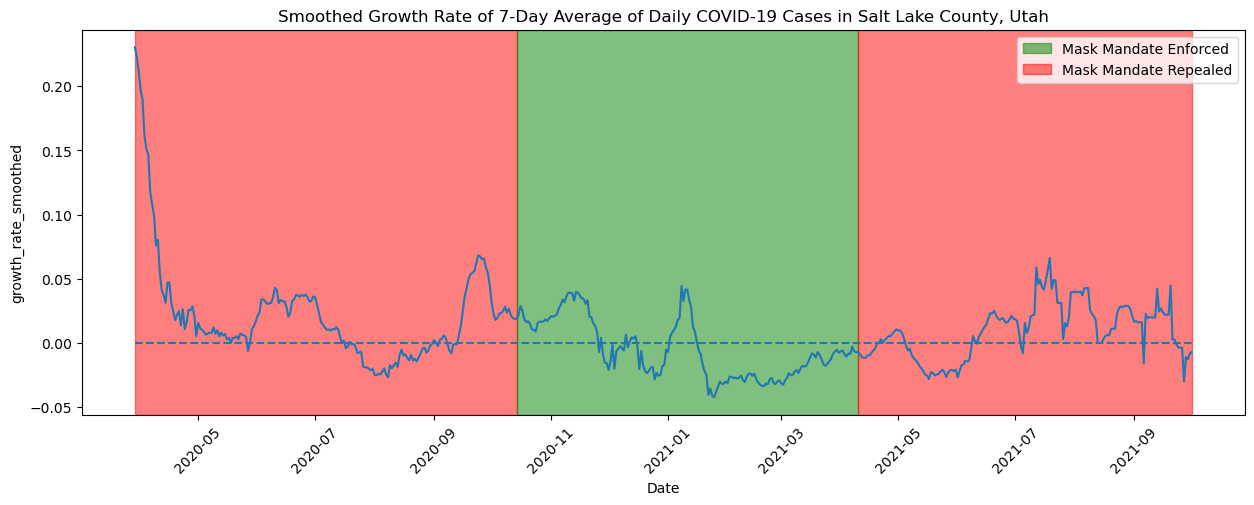

In [93]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=covid_cases.loc[67:,:], x="Date", y="growth_rate_smoothed");
ax.axvspan(mask_no_1[0], mask_no_1[1], alpha=0.5, color='red', label="_No Mask Mandate")
ax.axvspan(mask_yes[0], mask_yes[1], alpha=0.5, color='green', label="Mask Mandate Enforced")
ax.axvspan(mask_no_2[0], mask_no_2[1], alpha=0.5, color='red', label="Mask Mandate Repealed")
ax.legend()
ax.hlines(0, covid_cases.loc[67, "Date"], covid_cases["Date"].max(), linestyles='dashed')
plt.title("Smoothed Growth Rate of 7-Day Average of Daily COVID-19 Cases in Salt Lake County, Utah");
plt.xticks(rotation=45);